Where it says "Google Colab" should only be run, when the Jupyter notebook is placed in Google Colab.

The model is a Graph Neural Network, and it takes time to run, so it is recommended to run it on a GPU.

# Setup Google Drive (Google Colab)

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/INF554')

# Initialize (Google Colab)

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.6 MB/s eta 0:00:00


In [4]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e2103baafdd9a684f975307df9b10d8d7edb2fd35f437fd8acb2f8887600ee45
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


# Initialize

In [5]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn as nn
from torch_geometric.nn import GCNConv, RGCNConv
import torch.nn.functional as F
import torch
from torch_geometric.data import Data
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from sentence_transformers import SentenceTransformer
import sklearn
from sklearn.decomposition import PCA
from sklearn import model_selection
import copy
import xgboost as xgb
from xgboost import XGBClassifier
plt.style.use('seaborn')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

<ipython-input-5-ccf8230f9a36>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Load Functions

In [6]:
from functions.graph_functions import setup_graphs # Functions to set up graphs
from functions.F1_loss import F1_Loss # Loss functions to optimize F1_loss
from functions.utillity_functions import flatten, make_submission, split_graph, get_number_of_classifications,train_and_validation_split
from functions.setup_neural_networks import RGCN, GCN, MLP # Class for training graph neural network
from functions.PCA import rewrite_features # Function to decrease number of features using PCA
from functions.training_and_testing_functions import train, test

# Setup Graphs

In [8]:
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')
graph, graph_number = setup_graphs(training_set, train = True, illustrate = False,device=device)

  0%|          | 0/97 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

 40%|████      | 39/97 [29:11<43:56, 45.46s/it]

graph_norm, mu, sigma, pca = rewrite_features(graph,device=device,n_components=8,keep_out_features=4)

In [9]:
def plot_pca(v,num=6,save_name="pca"):
  v = v.cpu().numpy()
  cdict = {0: 'red', 1: 'blue'}
  color = [cdict[i] for i in graph.y.cpu().numpy()]
  fig, axes = plt.subplots(num,num,figsize=(20,20))
  for i in tqdm(range(num)):
    for j in range(num):
      Y = v[:,i]
      X = v[:,j]
      axes[i,j].scatter(X, Y, c = color, alpha = 0.2)
      axes[i,j].set_ylabel(f"PC{i+1}")
      axes[i,j].set_xlabel(f"PC{j+1}")
  plt.tight_layout()
  plt.savefig(f"results/{save_name}.png", dpi=300,bbox_inches='tight', pad_inches=0)
  plt.close()

In [10]:
def compute_pca(x,n_components=8):
  X = np.array(x.cpu().numpy())
  pca = PCA(n_components=n_components)
  Y = pca.fit_transform(X)
  return torch.tensor(Y.tolist(), dtype=torch.float).to(device), pca

In [11]:
v = graph.x[:,4:]

In [21]:
mean = torch.mean(v,0)
v_tilde = v - mean
u, pca = compute_pca(v_tilde,n_components=4)
#plot_pca(u,num=4,save_name="pca_before")
#a = torch.from_numpy(pca.components_[:4]).to(device)
#a_norm = a / a.norm()
#vnew = v_tilde - torch.matmul(torch.matmul(v_tilde, torch.t(a_norm)),a_norm)
unew, pcanew = compute_pca(v_tilde,n_components=100)
#plot_pca(unew,num=4,save_name="pca_after")
graph.x  = torch.hstack([graph.x[:, :4], unew[:, :4]])

In [15]:
test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])
graph_test, graph_number_test = setup_graphs(test_set, train = False, illustrate = False,device=device)

100%|██████████| 40/40 [01:51<00:00,  2.79s/it]


[0, 0, 4, 1, 1, 3, 2, 0, 0, 6, 2, 4, 1, 4, 4, 7, 6, 8, 7, 6, 4, 7, 6, 4, 7, 6, 8, 3, 7, 6, 0, 2, 2, 0, 2, 1, 2, 2, 8, 2, 5, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 9, 6, 4, 4, 2, 6, 2, 1, 13, 2, 0, 2, 0, 0, 0, 8, 0, 2, 0, 0, 3, 3, 3, 0, 6, 6, 4, 1, 7, 6, 6, 0, 8, 4, 4, 2, 4, 2, 3, 0, 3, 9, 4, 3, 2, 0, 3, 0, 6, 3, 6, 6, 6, 2, 2, 8, 8, 4, 2, 2, 1, 1, 1, 9, 10, 2, 2, 2, 5, 9, 9, 0, 5, 2, 1, 8, 3, 2, 10, 6, 0, 2, 2, 4, 2, 2, 0, 8, 0, 0, 2, 0, 3, 7, 8, 0, 8, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 2, 3, 3, 3, 0, 0, 3, 3, 0, 0, 4, 0, 3, 2, 2, 0, 2, 2, 0, 2, 8, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 8, 3, 2, 2, 8, 0, 0, 8, 3, 3, 3, 3, 3, 0, 6, 2, 1, 0, 8, 0, 5, 3, 2, 0, 2, 2, 0, 3, 0, 3, 0, 1, 0, 3, 1, 0, 2, 0, 0, 3, 3, 0, 0, 3, 1, 13, 1, 3, 2, 5, 0, 2, 0, 0, 0, 7, 6, 3, 6, 0, 6, 2, 0, 6, 14, 8, 11, 6, 2, 0, 0, 5, 3, 0, 8, 2, 8, 3, 0, 0, 4, 2, 2, 8, 3, 8, 8, 2, 1, 0, 0, 0, 0, 3, 7, 3, 3, 3, 4, 4, 0, 14, 8, 4, 4, 0, 3, 0, 3, 1, 7, 6, 0, 4, 3, 3, 2, 3, 0, 0, 4, 2, 0, 2, 0, 1, 2, 5, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2,

In [ ]:
graph_test, mu, sigma, pca = rewrite_features(graph_test,mu=mu,sigma=sigma,pca=pca,device=device,keep_out_features=4)

NameError: ignored

In [16]:
v_test = graph_test.x[:,4:]

In [24]:
v_test.shape

torch.Size([31026, 768])

In [22]:
v_tilde_test = v_test - mean
#plot_pca(u,num=8,save_name="pca_before")

#vnew_test = v_tilde_test - torch.matmul(torch.matmul(v_test, torch.t(a_norm)),a_norm)
unew_test = pcanew.fit_transform(v_tilde_test.cpu())
#plot_pca(unew[:, 4:],num=4,save_name="pca_after")
data = np.hstack((graph_test.x[:, :4].cpu(), unew_test[:, 4:]))

graph_test.x  = torch.tensor(data.tolist(), dtype = torch.float).to(device)

# Compare Different Models

In [18]:
from scipy.io import savemat, loadmat
compute_new = True
if compute_new:
  train_mask, val_mask = split_graph(graph_number,K=10) # Takes 1/10 as the validation set
  mdic = {"train_mask":train_mask,"val_mask":val_mask}
  savemat("split/train_and_val_mask.mat", mdic)
else:
  mdic = loadmat("split/train_and_val_mask.mat")
  train_mask = mdic["train_mask"]
  val_mask = mdic["val_mask"]


In [23]:
n_epochs = 200
lr = 1e-03

# XGBoost for comparison
X = graph.x.cpu().numpy()
y = graph.y.cpu().numpy()
X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
X_test = graph_test.x.cpu().numpy()
bst = XGBClassifier()
bst.fit(X_train,y_train)
yhat = bst.predict(X_val)
f1_score = sklearn.metrics.f1_score(y_val,yhat)
print(f"F1-score for XGBoost on the validation set is {f1_score}")

# Models
mlp = MLP(input_dimension=graph.x.shape[1]).to(device) # Linear model using only node features
gcn = GCN(hidden_units=[48],input_dimension=graph.x.shape[1]).to(device) # Graph Neural Network without edge types
rgcn = RGCN(hidden_units=[48],input_dimension=graph.x.shape[1]).to(device) # Graph Neural Network with edge types

# Setup Optimizers
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=lr)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=lr)
optimizer_rgcn = torch.optim.Adam(rgcn.parameters(), lr=lr)

# In order to get the best F1-score, we use F1-loss
criterion = F1_Loss()

# Train and test models
train_F1 = []
val_F1 = []
mlp, _, _, temp1, temp2 = train(mlp, graph, optimizer_mlp, criterion, train_mask, val_mask,n_epochs=n_epochs,output_evaluation=False)
train_F1.append(temp2)
val_F1.append(temp1)
gcn, _, _, temp1, temp2 = train(gcn, graph, optimizer_gcn, criterion, train_mask, val_mask,n_epochs=n_epochs,output_evaluation=False)
train_F1.append(temp2)
val_F1.append(temp1)
rgcn, _, _, temp1, temp2 = train(rgcn, graph, optimizer_rgcn, criterion, train_mask, val_mask,n_epochs=n_epochs,output_evaluation=False)
train_F1.append(temp2)
val_F1.append(temp1)

# See how many a classified important
print("\nLinear model:")
get_number_of_classifications(graph_test,mlp)
print("GCN:")
get_number_of_classifications(graph_test,gcn)
print("RGCN:")
get_number_of_classifications(graph_test,rgcn)
print("XGBoost:")
y_test = bst.predict(X_test)
print(f"Number of nodes predicted to be non-important: {sum(y_test==0)}")
print(f"Number of nodes predicted to be important: {sum(y_test==1)}")

F1-score for XGBoost on the validation set is 0.4487584650112867


100%|██████████| 200/200 [00:21<00:00,  9.27it/s]


Linear model:


RuntimeError: ignored

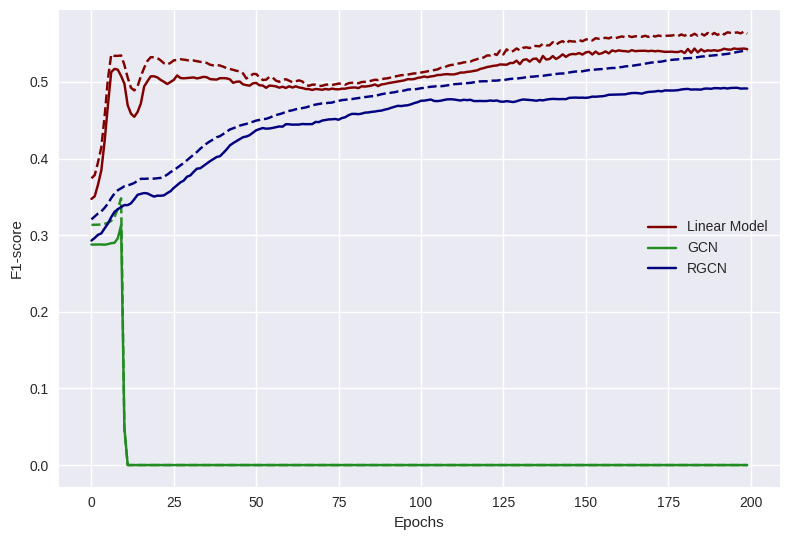

In [ ]:
color = ['maroon','forestgreen','navy']
labels = ['Linear Model','GCN','RGCN']
for i in range(3):
  plt.plot(val_F1[i],color=color[i],label=labels[i])
  plt.plot(train_F1[i],'--',color=color[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.tight_layout()
plt.savefig("results/comparison_of_models.png", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
pred = rgcn(graph_test).argmax(dim=1).cpu().numpy()

In [ ]:
sum(pred==1)

7959

In [ ]:
test_labels = {}
for idx, name in enumerate(test_set):
    test_labels[name] = pred[np.in1d(graph_number_test,idx)].tolist()
with open("results/test_labels_we_test.json", "w") as file:
    json.dump(test_labels, file, indent=4)
make_submission("results/test_labels_we_test.json",save_name='submission_rgcn')

# Building Cross-Validation

In [ ]:
def inner_cross_validation(graph,train_mask,val_mask,models,lr,n_epochs,num=None):
  F1 = []
  accuracy = []
  plt.figure()
  for idx, model in enumerate(models):
    rgcn = RGCN(hidden_units=model,input_dimension=graph.x.shape[1]).to(device)
    optimizer_gcn = torch.optim.Adam(rgcn.parameters(), lr=lr)
    criterion = F1_Loss()
    rgcn, val_acc, train_acc, val_F1, train_F1 = train(rgcn, graph, optimizer_gcn, criterion, train_mask, val_mask,n_epochs=n_epochs,output_evaluation=False)
    plt.plot(val_F1,label=f'Model {idx+1}')
    val_acc, F1_val = test(rgcn, graph, val_mask)
    F1.append(F1_val)
    accuracy.append(val_acc)
    print(f"Model {idx+1}:")
    print(f"\tF1-score: {F1_val}")
    print(f"\tAccuracy: {val_acc}")

  #plt.title("F1-score")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("F1-score")
  if num is not None:
    plt.tight_layout()
    plt.savefig(f"results/cross_loop_{num}.png", dpi=300,bbox_inches='tight', pad_inches=0)
  plt.show()

  return accuracy, F1

def outer_cross_validation(graph,graph_number,models,K=10,n_epochs=200,lr=1e-03):
  CV = model_selection.KFold(K, shuffle=True)
  indices = np.arange(max(graph_number)+1)

  all_accuracies = []
  all_F1 = []
  num = 1
  for train_idx, val_idx in CV.split(indices):

    train_mask, val_mask, _ = train_and_validation_split(graph_number,val_idx)

    accuracy, F1 = inner_cross_validation(graph,train_mask,val_mask,models,lr,n_epochs,num=num)
    all_accuracies.append(accuracy)
    all_F1.append(F1)
    num += 1

  mean_F1 = np.mean(np.array(all_F1),axis=0)
  return all_F1, mean_F1

In [ ]:
# models = [[256],[128],[64],[256,256],[128,128],[256,128]] # Old BERT
models = [[512],[256],[128],[256,256],[128,128],[512,256]]

all_F1, mean_F1 = outer_cross_validation(graph,graph_number,models,K=5,lr=1e-04,n_epochs=400)
all_F1, mean_F1

In [ ]:
models = [[72],[48],[24],[72,72],[48,48],[72,48]] # PCA

all_F1, mean_F1 = outer_cross_validation(graph,graph_number,models,K=5,lr=1e-04,n_epochs=400)
all_F1, mean_F1

Old BERT: array([0.41582437, 0.34746447, 0.34901132, 0.49991172, 0.49778165,
        0.50159765]))

In [ ]:
models = [[256],[256,128]]

all_F1, mean_F1 = outer_cross_validation(graph,graph_number,models,K=5,lr=1e-04,n_epochs=1000)
all_F1, mean_F1

In [ ]:
models = [[256],[256,128]]

all_F1, mean_F1 = outer_cross_validation(graph,graph_number_train,models,K=5,lr=1e-04,n_epochs=1000)
all_F1, mean_F1

# Train Final Model

In [ ]:
def train_one_model(graph,graph_number,model,K=10,n_epochs=200,lr=1e-03):
  CV = model_selection.KFold(K, shuffle=True)
  indices = np.arange(max(graph_number)+1)

  for train_idx, val_idx in CV.split(indices):

    train_mask, val_mask, _ = train_and_validation_split(graph_number,val_idx)
    rgcn = RGCN(hidden_units=model,input_dimension=graph.x.shape[1]).to(device)
    optimizer_gcn = torch.optim.Adam(rgcn.parameters(), lr=lr)
    criterion = F1_Loss()
    rgcn, val_acc, train_acc, val_F1, train_F1 = train(rgcn, graph, optimizer_gcn, criterion, train_mask, val_mask,n_epochs=n_epochs,output_evaluation=False)
    val_acc, F1_val = test(rgcn, graph, val_mask)


    print(f"\tF1-score: {F1_val}")
    print(f"\tAccuracy: {val_acc}")


    plt.figure()
    plt.plot(val_F1,label='Validation')
    plt.plot(train_F1,label='Training')
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")

    plt.tight_layout()
    plt.savefig("results/one_model.png", dpi=300,bbox_inches='tight', pad_inches=0)
    plt.show()

    break

  return val_F1, rgcn

#model = [256] # n_epochs=1200,lr=1e-04
model = [512] # n_epochs=1200,lr=1e-04
#model = [72] #PCA

val_F1, rgcn = train_one_model(graph,graph_number,model,K=40,n_epochs=3000,lr=1e-05)

 58%|█████▊    | 1739/3000 [39:32<28:20,  1.35s/it]

In [ ]:
np.max(val_F1),np.argmax(val_F1)

(0.5064935064935066, 2026)

In [ ]:
vals = np.array(range(310,len(val_F1),10))
correct = []
for val in tqdm(vals):
  rgcn_pos = torch.load(f'model_save/epoch_{val}.pt')
  pred_pos = rgcn_pos(graph_test).argmax(dim=1).cpu().numpy()
  correct.append((pred_pos==1).sum())


100%|██████████| 269/269 [01:30<00:00,  2.97it/s]


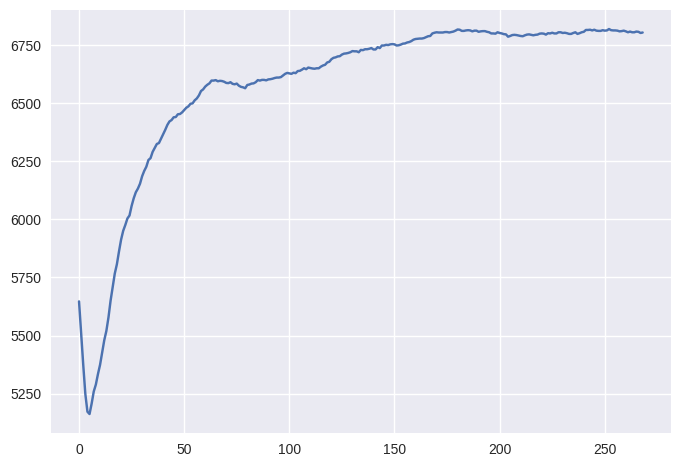

In [ ]:
plt.plot(correct)

In [ ]:
np.max(correct), np.argmax(correct), vals[np.argmax(correct)]

(8561, 22, 530)

In [ ]:
val_F1[510]

0.605296343001261

In [ ]:
best = np.argmax(val_F1)+1
best=2580
rgcn_test = torch.load(f'model_save/epoch_{best}.pt')
#rgcn_test = torch.load(f'model_save/epoch_{1500}.pt')

In [ ]:
rgcn_test = rgcn

In [ ]:
pred = rgcn_test(graph_test).argmax(dim=1).cpu().numpy()
# See how many a classified important
get_number_of_classifications(graph_test,rgcn)

(24217, 6809)

Save in json file and then csv

In [ ]:
test_labels = {}
for idx, name in enumerate(test_set):
    test_labels[name] = pred[np.in1d(graph_number_test,idx)].tolist()
with open("results/test_labels_we_test.json", "w") as file:
    json.dump(test_labels, file, indent=4)
make_submission("results/test_labels_we_test.json",save_name='submission_hele_dataset_6809')

In [ ]:
with open("results/test_labels_we_test.json", "w") as file:
    json.dump(test_labels, file, indent=4)

In [ ]:
make_submission("results/test_labels_we_test.json",save_name='submission_hele_dataset_6809')

7388, 7393, 7498